In [2]:
import numpy as np
from keras.models import model_from_json
import tensorflow as tf
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import rasterio
import cv2
from PIL import Image
from skimage.transform import resize

In [3]:
model = tf.keras.models.load_model("prev_trained_model/model_weights_resnet.h5", compile=False)


In [4]:
image_file = 'images.tif'

In [5]:
def features(image_file):
    img = load_img(image_file, color_mode='rgb')
    img = img_to_array(img)
    img = resize(img, (256,256))  # Resize the image to the expected shape
    img = np.expand_dims(img, axis=0)
    return img/255.

In [6]:
img = features(image_file)
pred = model.predict(img)

1/1 [==============================] - 35s 35s/step


In [7]:
pred

array([[[[0.17847589],
         [0.1488245 ],
         [0.14850274],
         ...,
         [0.13539827],
         [0.1457326 ],
         [0.16579807]],

        [[0.14883006],
         [0.13704173],
         [0.13549434],
         ...,
         [0.11589642],
         [0.12952451],
         [0.14437738]],

        [[0.15602043],
         [0.14425923],
         [0.14330496],
         ...,
         [0.12397939],
         [0.1283573 ],
         [0.14785403]],

        ...,

        [[0.1633903 ],
         [0.14297782],
         [0.14765759],
         ...,
         [0.30983463],
         [0.3078176 ],
         [0.31781778]],

        [[0.1509023 ],
         [0.1362792 ],
         [0.14444695],
         ...,
         [0.3064198 ],
         [0.2627381 ],
         [0.32397273]],

        [[0.17186424],
         [0.15579052],
         [0.15197113],
         ...,
         [0.32915145],
         [0.3158529 ],
         [0.27415144]]]], dtype=float32)

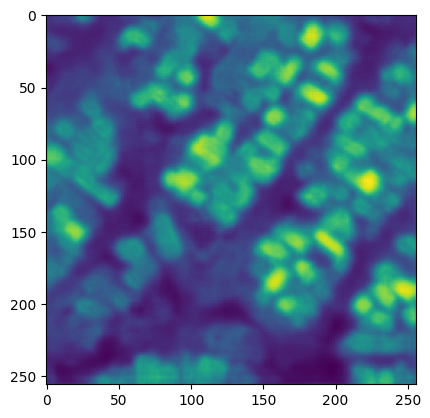

In [8]:
plt.imshow(pred[0])
plt.axis('on')  # Remove axis
plt.show()

In [9]:
class_labels = ['Background', 'Rooftop',...]
pred_mask = pred[0]

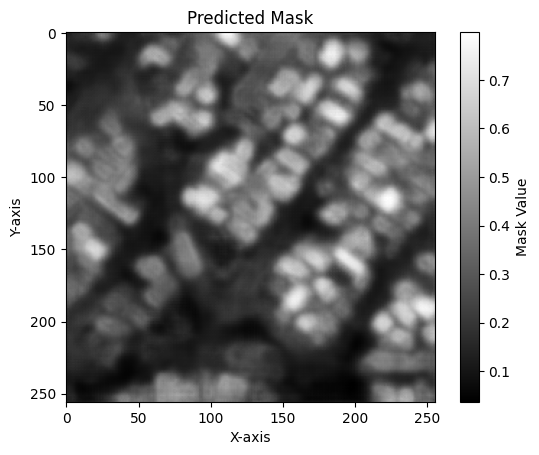

In [10]:
pred_mask = pred[0, :, :, 0]
fig, ax = plt.subplots()
im = ax.imshow(pred_mask, cmap='gray')
ax.set_title('Predicted Mask')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Mask Value')


In [10]:
with rasterio.open('predicted_mask.tif', 'w', 
                   driver='GTiff', 
                   height=pred_mask.shape[0], 
                   width=pred_mask.shape[1], 
                   count=1, 
                   dtype=rasterio.uint8) as dst:
    dst.write(pred_mask.astype(rasterio.uint8), 1)


C:\Users\raksh\miniconda3\lib\site-packages\rasterio\__init__.py:327: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [17]:
# with rasterio.open('images.tif') as src:
#     print(src.res)

In [200]:
# masked_area = np.sum(pred_mask > 0)
# print(f'Masked area: {masked_area} pixels')

In [16]:
from scipy.ndimage import gaussian_filter

In [34]:
blurred_pred = gaussian_filter(pred[0], sigma=3)
sharpened_pred = pred[0]-blurred_pred

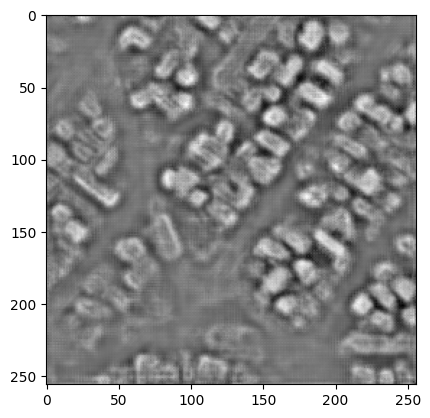

In [36]:
plt.imshow(sharpened_pred,cmap="grey")

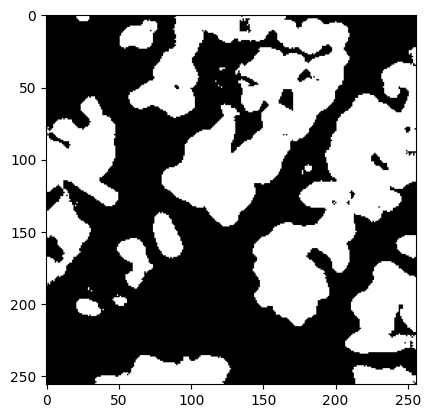

In [206]:
threshold = 0.3  # adjust this value as needed
binary_mask = (pred[0] > threshold).astype(np.uint8)
plt.imshow(binary_mask, cmap="grey")


In [228]:
original_image = cv2.imread('images.tif')
resized_image = cv2.resize(original_image, (256, 256))
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
image_array = grayscale_image.reshape((256, 256, 1))



In [230]:
result_image = image_array.copy()
result_image[binary_mask == 1] = (255)  

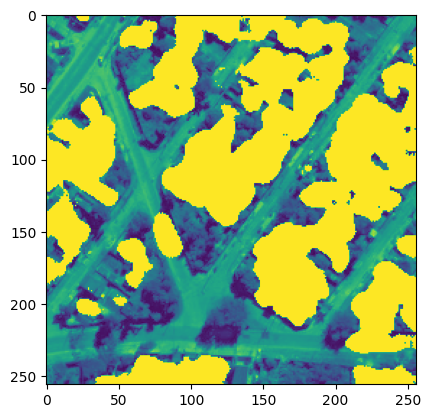

In [231]:
plt.imshow(result_image)
plt.show()

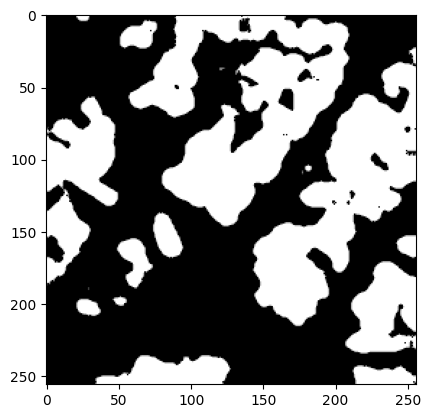

In [101]:
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

  # Apply unsharp masking
blurred = cv2.filter2D(binary_mask, -1, kernel)
sharpened = cv2.addWeighted(binary_mask, 5, blurred, -0.5, 250)
plt.imshow(sharpened, cmap="grey")

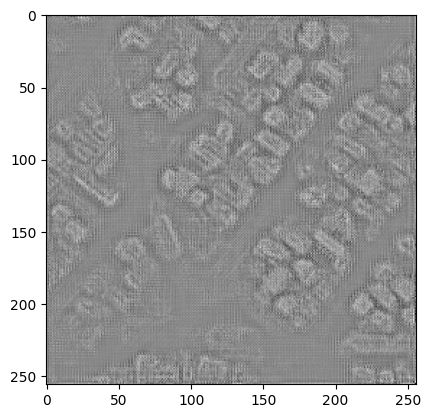

In [157]:
ksize = 5  # Adjust kernel size for desired effect
sigma = 0.5  # Adjust sigma for noise reduction
gaussian_kernel = cv2.getGaussianKernel(ksize, sigma) # Define high-pass filter kernel (Laplacian)
highpass_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# Apply Gaussian filter
blurred = cv2.filter2D(pred[0], -1, gaussian_kernel)

# Apply high-pass filter
sharpened = cv2.filter2D(blurred, -1, highpass_kernel)
plt.imshow(sharpened , cmap="grey")

In [187]:
image_array_clipped = np.clip(sharpened, 0, None)
print(image_array_clipped)

[[0.09047079 0.         0.00760478 ... 0.00639653 0.01437049 0.06631155]
 [0.00437582 0.         0.         ... 0.         0.         0.01751336]
 [0.01822948 0.         0.         ... 0.         0.         0.03903939]
 ...
 [0.0445106  0.         0.00792508 ... 0.         0.         0.02466363]
 [0.01007766 0.         0.00072195 ... 0.00043395 0.         0.120967  ]
 [0.05739452 0.01061317 0.00900842 ... 0.02668899 0.06267014 0.        ]]


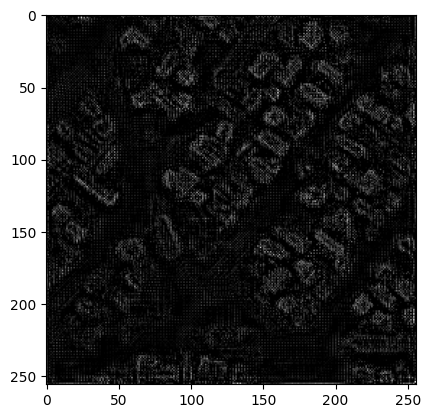

In [188]:
plt.imshow(image_array_clipped, cmap="grey")

In [196]:
masked_area = np.sum(image_array_clipped > 0)
print(f'Masked area: {masked_area} pixels')

Masked area: 31470 pixels
